In [1]:
import numpy as np
import time
from annchor.datasets import load_digits,load_digits_large
import matplotlib.pyplot as plt

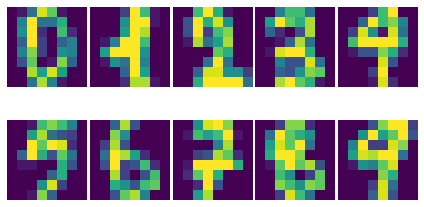

In [2]:
k=25

X = load_digits_large()['X']
y = load_digits_large()['y']
neighbor_graph = load_digits_large()['neighbor_graph']

nx = X.shape[0]

fig,axs = plt.subplots(2,5)
axs = axs.flatten()
for i,ax in enumerate(axs):
    ax.imshow(X[y==i][0].reshape(8,8))
    ax.axis('off')

plt.tight_layout(h_pad=0.1, w_pad=0.3)
plt.show()

In [3]:
from annchor.distances import wasserstein
from annchor import compare_neighbor_graphs



In [ ]:
from numba import njit

def get_new_bounds(ann):
    II,JJ = np.meshgrid(np.arange(ann.nx),np.arange(ann.nx))
    newD = ann.RefineApprox.copy()
    newD[II>JJ]*=(~ann.not_computed_mask)
    newD[II>JJ]-=ann.not_computed_mask
    newD[II<JJ]*=0
    newD+=newD.T


    @njit
    def get_approx(D,A,nx):
        Approx = np.zeros(shape=(nx, nx,2))
        DaD =  np.zeros(shape=(nx, nx))
        for i in prange(nx-1):
            imask = D[i]>-1
            #for a in A:
            #    imask[a]=False
            for j in prange(i+1,nx):
                mask = imask*(D[j]>-1)
                #mask[ann.A]=False

                djm = D[j][mask]
                dim = D[i][mask]

                lb = np.max(np.abs(dim - djm))
                ub = np.min(dim+djm)

                DaD[i,j] = (dim[np.argmin(djm)]+
                      djm[np.argmin(dim)])

                Approx[i,j,0] = lb
                Approx[j,i,0] = lb
                Approx[i, j, 1] = ub
                Approx[j,i,1] = ub

        return Approx,DaD/2

    return get_approx(newD,ann.A,ann.nx)

In [ ]:
from annchor import Annchor
from annchor.components import *

from sklearn.neighbors import KNeighborsRegressor as KNR
from sklearn.linear_model import LinearRegression as LR


start_time = time.time()

# Call ANNchor
ann = Annchor(X,
              wasserstein,
              n_anchors=30,
              n_neighbors=k,
              n_samples=5000,
              refine_cycles=1,
              p_work=0.01,              
             )

ann.get_anchors()
ann.get_features()
ann.get_sample()

ann.fit_predict_regression()

fig,ax = plt.subplots(figsize=(13,5))
iy = np.argsort(ann.sample_y)
ax.plot(ann.sample_features[iy,2:5],'.',alpha=0.4)
ax.plot(ann.sample_predict[iy],'.',alpha=0.4)
ax.plot(ann.sample_y[iy])
plt.show()

ann.fit_predict_errors()
ann.select_candidate_pairs(0.5)
ann.refine_approx()

if True:
    II,JJ = np.meshgrid(np.arange(ann.nx),np.arange(ann.nx))


    #RA = ann.RefineApprox.copy()
    appr,dad = get_new_bounds(ann)
    ann.features[:,2:4]=appr[II>JJ]
    ann.features[:,4]=dad[II>JJ]


    ann.get_sample()
    ann.fit_predict_regression()
    ann.fit_predict_errors()
    #ann.RefineApprox = RA.copy()
    #for sample_ij,y in zip(ann.sample_ijs,ann.sample_y):
    #    i,j = sample_ij
    #    ann.RefineApprox[i,j]=y
    #    ann.RefineApprox[j,i]=y

    fig,ax = plt.subplots(figsize=(13,5))
    iy = np.argsort(ann.sample_y)
    ax.plot(ann.sample_features[iy,2:5],'.',alpha=0.4)
    ax.plot(ann.sample_predict[iy],'.',alpha=0.4)
    ax.plot(ann.sample_y[iy])
    plt.show()


ann.select_candidate_pairs(0.5)
ann.refine_approx()

ann.get_ann()
print('ANNchor Time: %5.3f seconds' % (time.time()-start_time))


## Test accuracy
error = compare_neighbor_graphs(neighbor_graph,
                                ann.neighbor_graph,
                                k)
print('ANNchor Accuracy: %d incorrect NN pairs (%5.3f%%)' % (error,100*error/(k*nx)))
print('ANNchor Evals: %d function calls (%5.3f%% of brute force)' % (ann.evals,
                                                       100*ann.evals/(ann.nx*(ann.nx-1)/2)
                                                      )
     )



In [ ]:
stop

In [ ]:
II,JJ = np.meshgrid(np.arange(ann.nx),np.arange(ann.nx))
newD = ann.RefineApprox.copy()
newD[II>JJ]*=(~ann.not_computed_mask)
newD[II>JJ]-=ann.not_computed_mask
newD[II<JJ]*=0
newD+=newD.T

In [ ]:
newD[0][(newD[0]>-1)*(newD[1]>-1)]

In [ ]:
mask = (newD[0]>-1)*(newD[1]>-1)
mask[ann.A]=False
np.any(mask)

In [ ]:
from numba import njit

def get_new_bounds(ann):
    II,JJ = np.meshgrid(np.arange(ann.nx),np.arange(ann.nx))
    newD = ann.RefineApprox.copy()
    newD[II>JJ]*=(~ann.not_computed_mask)
    newD[II>JJ]-=ann.not_computed_mask
    newD[II<JJ]*=0
    newD+=newD.T


    @njit
    def get_approx(D,A,nx):
        Approx = np.zeros(shape=(nx, nx,2))
        DaD =  np.zeros(shape=(nx, nx))
        for i in prange(nx-1):
            imask = D[i]>-1
            #for a in A:
            #    imask[a]=False
            for j in prange(i+1,nx):
                mask = imask*(D[j]>-1)
                #mask[ann.A]=False

                djm = D[j][mask]
                dim = D[i][mask]

                lb = np.max(np.abs(dim - djm))
                ub = np.min(dim+djm)

                DaD[i,j] = (dim[np.argmin(djm)]+
                      djm[np.argmin(dim)])

                Approx[i,j,0] = lb
                Approx[j,i,0] = lb
                Approx[i, j, 1] = ub
                Approx[j,i,1] = ub

        return Approx,DaD/2

    return get_approx(newD,ann.A,ann.nx)

In [ ]:
appr,dad = get_new_bounds(ann)

In [ ]:
dad[II>JJ]

In [ ]:
np.sum( ~(ann.features[:,4] ==dad[II>JJ][:]))

In [ ]:
fig,ax = plt.subplots()
ax.hist( (ann.Bounds[:,:,1]-ann.Bounds[:,:,0]).flatten(),bins=100)
ax.hist( (newBounds[:,:,1]-newBounds[:,:,0]).flatten(),bins=100,alpha=0.7)


plt.show()

In [ ]:
fig,ax = plt.subplots(figsize=(13,5))

iy = np.argsort(ann.sample_y)

ax.plot(ann.sample_features[iy,2:4],'.',alpha=0.4)
ax.plot(ann.sample_predict[iy],'.',alpha=0.4)

#ax.plot(newBounds[II>JJ][ann.sample_ixs][iy])
ax.plot(ann.sample_y[iy])

In [ ]:
@njit(parallel=True,fastmath=True)
def get_approx_njit(D,nx):
    Approx = np.zeros(shape=(nx, nx, 2))
    for i in prange(nx-1):
        for j in prange(i+1,nx):
            lb = np.max(np.abs(D[i] - D[j]))
            ub = np.min(D[i] + D[j])


            Approx[i,j,0] = lb
            Approx[j,i,0] = lb
            Approx[i, j, 1] = ub
            Approx[j,i,1] = ub

    return Approx

In [ ]:
fig,ax = plt.subplots(figsize=(20,10))
ax.vlines([i*714 for i in range(8)],0,2.5,'k')
ix = np.argsort(ann.sample_y)
ax.plot(ann.sample_features[ix,2:-1],'.',alpha=0.3)
ax.plot(ann.sample_features[ix,4]/2,'.',alpha=0.3)


ax.plot(ann.sample_predict[ix],'.',alpha=0.3)
ax.plot(ann.sample_y[ix],'.',alpha=0.3)






In [ ]:
from collections import Counter
Counter(np.argmin(ann.D,axis=1))

In [ ]:
from tqdm.notebook import tqdm as tq
nx = ann.nx
na = 1
np.random.seed(ann.random_seed)

# D stores distances to anchor points
# note: at this point D is shape (n_anchors, nx),
#       but we transpose this after calculations.
D = np.zeros((na, nx)) + np.infty

# A stores anchor indices
A = np.zeros(na).astype(int)
ix = np.random.randint(nx)

#get_dists = get_dists_(ann.f,ann.low_cpu)

for i in tq(range(na)):
    A[i] = ix  
    D[i] = get_dists(ix,ann.f,ann.X,nx)
    ix = np.argmax(np_min(D, 0))



In [ ]:
D

In [ ]:
get_dists(ix,ann.f,ann.X,nx)

In [ ]:
a,b = set(ann.neighbor_graph[0][31]),set(neighbor_graph[0][31,:25].astype(int))
a.difference(b),b.difference(a)

In [ ]:
ann.RefineApprox[31,845],ann.RefineApprox[31,159]

In [ ]:
ann.f(ann.X[31],ann.X[159])

In [ ]:
ann.Bounds[31,845],ann.Bounds[31,159]